In [55]:
import pickle
import imageio
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import skimage.morphology as morph
from skimage.transform import resize
from matplotlib.colors import rgb_to_hsv
from skimage.feature import local_binary_pattern, hog

In [56]:
#Funtion to remove the noise and make the image smoother.
def median_filter(img, filterSize=3):
  filterRadius = filterSize//2
  img_pad = np.pad(img, ((filterRadius, ),(filterRadius, )), 'edge')

  filtered_img = np.zeros(img_pad.shape)
  for x in np.arange(filterRadius, img_pad.shape[0]-filterRadius+1):
    for y in np.arange(filterRadius, img_pad.shape[1]-filterRadius+1):
      med_region = np.median(img_pad[x-filterRadius:x+filterRadius+1, y-filterRadius:y+filterRadius+1])
      filtered_img[x,y] = med_region

  return filtered_img[filterRadius:img_pad.shape[0]-filterRadius, filterRadius:img_pad.shape[1]-filterRadius]

In [57]:
#This function is used to change the image range to (0, 255).
def normalize(img):
    img_new = (((img - np.amin(img))*255)/(np.amax(img) - np.amin(img))).astype(np.uint8)
    return img_new

In [58]:
#In this function we are pre processing the image.
#First, we resize the original image to standardize the size of all images.
#Secornd, we remove the colors and use the grayscale image.
#Third, we applay the median filter, it makes the image smoother and preserves the borders.
#Finally, we applay an edge detection and return the processed image.
def preprocessing(img):
  aux = resize(img, (150, 150, 3), anti_aliasing=False)
  aux = rgb_to_hsv(aux)
  aux = normalize(aux[:,:,2])
  aux = median_filter(aux)
  aux = aux - morph.erosion(aux, morph.disk(2))

  return aux

In [59]:
#Here we are reading three images that are not in the training set.
img_p = imageio.imread('Paper.jpg')
img_s = imageio.imread('Scissor.jpg')
img_r = imageio.imread('Rock.jpg')

In [60]:
#Preprocessing the image to extract features.
img_p_processed = preprocessing(img_p)
img_s_processed = preprocessing(img_s)
img_r_processed = preprocessing(img_r)

(-0.5, 149.5, 149.5, -0.5)

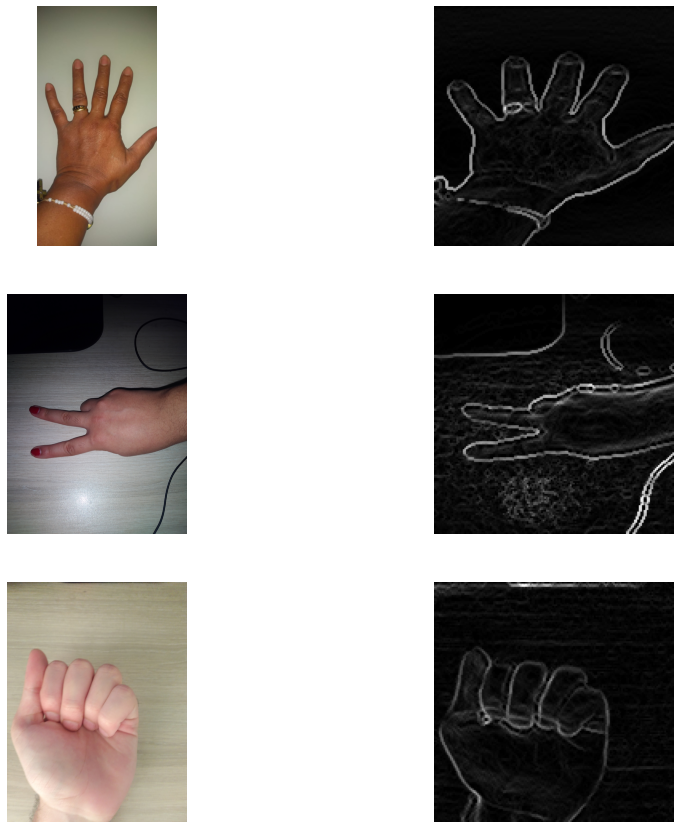

In [61]:
#the image on the right is the result after the preprocessing of the image on the left.
plt.figure(figsize=(15,15))
plt.subplot(321); plt.imshow(img_p); plt.axis('off')
plt.subplot(322); plt.imshow(img_p_processed, cmap='gray'); plt.axis('off')

plt.subplot(323); plt.imshow(img_s); plt.axis('off')
plt.subplot(324); plt.imshow(img_s_processed, cmap='gray'); plt.axis('off')

plt.subplot(325); plt.imshow(img_r); plt.axis('off')
plt.subplot(326); plt.imshow(img_r_processed, cmap='gray'); plt.axis('off')


In [62]:
#In these section we are extracting the features from the processed image.
#First, we take the LBP matrix and trasform it into a histogram array.
#Then we calculate the HOG as an 1-D array and join both arrays into one feature array.
aux = local_binary_pattern(img_p_processed, 8, 1)
hist, bins = np.histogram(aux, int(aux.max() + 1), density=True)
hog_v = hog(img_p_processed, feature_vector=True)
features_p = np.append(hist,hog_v)

aux = local_binary_pattern(img_s_processed, 8, 1)
hist, bins = np.histogram(aux, int(aux.max() + 1), density=True)
hog_v = hog(img_s_processed, feature_vector=True)
features_s = np.append(hist,hog_v)

aux = local_binary_pattern(img_r_processed, 8, 1)
hist, bins = np.histogram(aux, int(aux.max() + 1), density=True)
hog_v = hog(img_r_processed, feature_vector=True)
features_r = np.append(hist,hog_v)

#Finally, we join all three feature arrays.
features = np.vstack((features_p, features_s, features_r))
#In this case, the first row represents paper, the second represents scissor and the third represents rock

In [63]:
#Now we load a calssifier that already has been trained and use it to classify the feature matrix.
loaded_model = pickle.load(open('finalized_model.sav', 'rb'))
y = loaded_model.predict(features)

#For each image we print the predicted class.
for i in range(y.size):
  if y[i] == 1: print('Paper')
  elif y[i] == 2: print('Scissor')
  elif y[i] == 3: print('Rock')


Paper
Scissor
Rock
